In [1]:
import numpy as np
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline

In [3]:
dataset2 = pd.read_csv('function1_2d.csv',index_col = 0)

In [4]:
x1_ds2 = np.array(dataset2)[:,0]
x2_ds2 = np.array(dataset2)[:,1]
y_ds2 = np.array(dataset2)[:,2]

In [5]:
def RMSE(y_pred, t):
    n = len(y_pred)
    return(np.sqrt(np.sum((y_pred - t)**2)/n))
    

In [6]:
def pseudo_inv(ph,lam,phit):
    return(np.matmul(np.linalg.inv(np.matmul(np.transpose(ph),ph)+lam*phit),np.transpose(ph)))

In [22]:
def regularized_pseudo_inv(lamb,phi):
    return(np.matmul(np.linalg.inv(lamb*np.identity(phi.shape[1])+np.matmul(np.transpose(phi),phi)),np.transpose(phi)))

In [7]:
def opt_param(phi,y,l,phit):
    return(np.matmul(pseudo_inv(phi,l,phit),y))

In [20]:
def opt_reg_param(lamb,phi,y):
    return(np.matmul(regularized_pseudo_inv(lamb,phi),y))

In [8]:
def y_pred(phi,w):
    return(np.matmul(phi,w))

In [9]:
def create_datasets(data,train_size,cv_size):
    data.sample(frac=1).reset_index(drop=True)
    data_train=data[0:train_size]
    data_cv=data[train_size:train_size+cv_size]
    data_test=data[cv_size+train_size:]
    return(data_train,data_cv,data_test)
    

In [10]:
def k_means(D,X):
    # X has dim (Nxd)
    # what is D?
    K = D-1
    d = X.shape[1]
    n = len(X)
    rand = list(np.random.randint(0,n,K))
    mu = X[rand]
    z = np.ones((n,K))
    z1 = np.zeros((n,K))
    flag = 0
    while((z==z1).all()!=1):
        z=z1
        z1 = np.zeros((n,K))
        for i in range(n):
            #print(X[i] - mu)
            j = np.argmin(np.linalg.norm(X[i] - mu, axis = 1))
            #print(np.linalg.norm(X[i] - mu, axis = 1))
            #print("hi")
            z1[i,j] = 1
        N = np.sum(z1,axis = 0)
        N = np.transpose(np.tile(N**(-1),(d,1)))
        #print(N.shape,z.shape,X.shape)
        mu = N*np.matmul(np.transpose(z1),X)
        flag +=1
        #print(z1)
        #print(z)
        #print(flag)
    return(mu)
    

In [11]:
def gaussian_basis(mu,X,sigma):
    #mu D-1*d len
    # x n*d
    D = len(mu)+1
    n = len(X)
    res = np.ones((n,D))
    for i in range(n):
        for j in range(1,D):
            res[j] = np.exp(-(np.linalg.norm(X[i]-mu[j-1])**2)/sigma**2)
    return(res)

In [13]:
trDS2, cvDS2, tDS2 = create_datasets(dataset2,1400,400)

In [14]:
X_ds2tr = np.array(trDS2)[:,0:2]
X_ds2cv = np.array(cvDS2)[:,0:2]
X_ds2t = np.array(tDS2)[:,0:2]# data features, DS2

In [15]:
y_ds2tr = np.array(trDS2)[:,2] 
y_ds2cv = np.array(cvDS2)[:,2] 
y_ds2t = np.array(tDS2)[:,2] 

In [16]:
clusters = np.array([1,3,10,30])

In [17]:
lambda_list=[0.1,0.3,1,3,10,30,100,300,1000]

In [18]:
def func_cl(c,sig):
    mus_tr = k_means(c,X_ds2tr)
    mus_cv = k_means(c,X_ds2cv) 
    mus_t = k_means(c,X_ds2t)
    phi_gausDS2tr = gaussian_basis(mus_tr,X_ds2tr,sig)
    phi_gausDS2cv = gaussian_basis(mus_cv,X_ds2cv,sig)
    phi_gausDS2t = gaussian_basis(mus_t,X_ds2t,sig)
    y_trpred={}
    y_cvpred={}
    y_tpred={}
    rmse_tr=[]
    rmse_cv=[]
    rmse_t=[]
    for l in lambda_list:
        w = opt_reg_param(l,phi_gausDS2tr,y_ds2tr)
        y_trpred[l] = y_pred(phi_gausDS2tr,w)
        y_cvpred[l] = y_pred(phi_gausDS2cv,w)
        y_tpred[l] = y_pred(phi_gausDS2t,w)
        rmse_tr.append(RMSE(y_trpred[l],y_ds2tr))
        rmse_cv.append(RMSE(y_cvpred[l],y_ds2cv))
        rmse_t.append(RMSE(y_tpred[l],y_ds2t))
        
    datagausDS2 = pd.DataFrame(list(zip(lambda_list,rmse_tr,rmse_cv,rmse_t)),columns=["Lambda", "RMSE Train","RMSE CV","RMSE test"])
    print(datagausDS2)
    rmse_min = np.argmin(rmse_cv)
    return(rmse_cv[rmse_min],lambda_list[rmse_min])

In [23]:
for cl in range(1,10):
    print(cl, func_cl(cl,0.25))

   Lambda    RMSE Train       RMSE CV     RMSE test
0     0.1  39276.384161  38316.619773  37068.425318
1     0.3  39276.384904  38316.458149  37068.334868
2     1.0  39276.393348  38315.898815  37068.024686
3     3.0  39276.467348  38314.354925  37067.193040
4    10.0  39277.300231  38309.575389  37064.910604
5    30.0  39284.399779  38301.061489  37063.562196
6   100.0  39357.253903  38323.879681  37111.630953
7   300.0  39839.578043  38695.615949  37553.577189
8  1000.0  42320.636510  40991.046045  40034.226392
1 (38301.0614886363, 30)
   Lambda    RMSE Train       RMSE CV     RMSE test
0     0.1  39330.868708  38468.309973  37654.616234
1     0.3  39330.868894  38468.224750  37654.539782
2     1.0  39330.871000  38467.928051  37654.273801
3     3.0  39330.889488  38467.093878  37653.527553
4    10.0  39331.098679  38464.331173  37651.074437
5    30.0  39332.909410  38457.756278  37645.399514
6   100.0  39352.455871  38449.147328  37640.104080
7   300.0  39500.558506  38526.139063  

clusters = 7, lambda = 300

In [25]:
mus_tr = k_means(7,X_ds2tr)
mus_cv = k_means(7,X_ds2cv) 
mus_t = k_means(7,X_ds2t)

In [26]:
phi_gausDS2tr = gaussian_basis(mus_tr,X_ds2tr,0.25)
phi_gausDS2cv = gaussian_basis(mus_cv,X_ds2cv,0.25)
phi_gausDS2t = gaussian_basis(mus_t,X_ds2t,0.25)# D = 7, sigma = 0.25, gaussian basis

In [27]:
y_tpred={}
y_trpred={}
y_cvpred={}
lambda_list=[0.1,0.3,1,3,10,30,100,300,1000]
rmse_tr=[]
rmse_t=[]
rmse_cv=[]

In [29]:
for l in lambda_list:
    w = opt_reg_param(l,phi_gausDS2tr,y_ds2tr)
    y_trpred[l] = y_pred(phi_gausDS2tr,w)
    y_cvpred[l] = y_pred(phi_gausDS2cv,w)
    y_tpred[l] = y_pred(phi_gausDS2t,w)
    rmse_tr.append(RMSE(y_trpred[l],y_ds2tr))
    rmse_t.append(RMSE(y_tpred[l],y_ds2t))
    rmse_cv.append(RMSE(y_cvpred[l],y_ds2cv))

In [30]:
datagausDS2 = pd.DataFrame(list(zip(lambda_list,rmse_tr,rmse_cv,rmse_t)),columns=["Lambda", "RMSE Train","RMSE CV","RMSE test"])

In [31]:
datagausDS2 

,Lambda,RMSE Train,RMSE CV,RMSE test
0,0.1,39378.033612,38402.435287,38068.495104
1,0.3,39378.033628,38402.416515,38068.474186
2,1.0,39378.033800,38402.350938,38068.401102
3,3.0,39378.035317,38402.164667,38068.193379
4,10.0,39378.052545,38401.525407,38067.479025
5,30.0,39378.203323,38399.807091,38065.546051
6,100.0,39379.892579,38395.030697,38060.017284
7,300.0,39394.102670,38391.404140,38054.234901
8,1000.0,39533.823221,38475.505656,38130.813305


In [32]:
bestLambda_gausDS2 = 300

In [33]:
w_bestGausDS2 = opt_reg_param(bestLambda_gausDS2,phi_gausDS2tr,y_ds2tr)
y_bestGausDS2tr = y_pred(phi_gausDS2tr,w_bestGausDS2 )

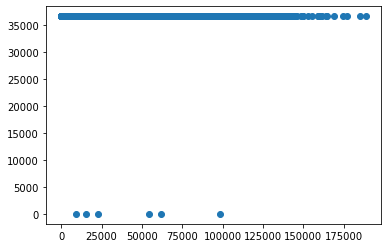

In [36]:
plt.scatter(y_ds2tr,y_bestGausDS2tr)
#plt.ylim(36200,36230)

In [37]:
def tikhanov_reg(phi,mu,sigma,l):
    K = len(mu)
    phiT = np.zeros((K+1,K+1))
    phiT[0,0] = 1
    for i in range(1,K+1):
        for j in range(1,K+1):
            phiT[i,j] = np.exp(-(np.linalg.norm(mu[i-1]-mu[j-1])**2)/sigma**2)
    #l = 300
    return(pseudo_inv(phi,l,phiT))

In [38]:
def func_cl_T(c,sig):
    mus_tr = k_means(c,X_ds2tr)
    mus_cv = k_means(c,X_ds2cv) 
    phi_gausDS2tr = gaussian_basis(mus_tr,X_ds2tr,sig)
    phi_gausDS2cv = gaussian_basis(mus_cv,X_ds2cv,sig)
    y_trpred={}
    y_cvpred={}
    rmse_tr=[]
    rmse_cv=[]
    for l in lambda_list:
        w = np.matmul( tikhanov_reg(phi_gausDS2tr,mus_tr,sig,l),y_ds2tr)
        y_trpred[l] = y_pred(phi_gausDS2tr,w)
        y_cvpred[l] = y_pred(phi_gausDS2cv,w)
        rmse_tr.append(RMSE(y_trpred[l],y_ds2tr))
        rmse_cv.append(RMSE(y_cvpred[l],y_ds2cv))
    #datagausDS2 = pd.DataFrame(list(zip(lambda_list,rmse_tr,rmse_cv,rmse_t)),columns=["Lambda", "RMSE Train","RMSE CV","RMSE test"])
    #print(datagausDS2)
    rmse_min = np.argmin(rmse_cv)
    return(rmse_cv[rmse_min],lambda_list[rmse_min])

In [39]:
for cl in range(1,10):
    print(cl, func_cl_T(cl,0.25))

1 (38301.0614886363, 30)
2 (38449.147327917155, 100)
3 (38418.60806750772, 100)
4 (38421.301218271525, 100)
5 (38472.15793330792, 300)
6 (38436.067052691404, 300)
7 (38391.40414039371, 300)
8 (38468.27992016303, 300)
9 (38669.6062811311, 300)


In [40]:
phiTds2 = tikhanov_reg(phi_gausDS2tr,mus_tr,0.25,300)

In [41]:
wTikhds2 = np.matmul(phiTds2,y_ds2tr)

In [42]:
yTikhds2 = y_pred(phi_gausDS2tr,wTikhds2)

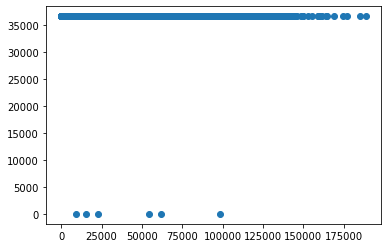

In [43]:
plt.scatter(y_ds2tr,yTikhds2)